In [1]:
import rasterio
import numpy as np
import h3ronpy
from h3ronpy.raster import nearest_h3_resolution
from h3ronpy.pandas.raster import raster_to_dataframe
from matplotlib import pyplot as plt
import pandas as pd
import h3
import copy
from rasterio.warp import calculate_default_transform, reproject, Resampling
import os

In [112]:
# amewoo, lobcur, buwtea, tunswa, sursco, bkpwar, sheowl
species = 'sheowl'

resolution = 4
resolution_factor = 0.1


# Define bounding box in EPSG:432.
bounds = (-170, -60, -30, 85)

In [113]:
os.makedirs(f"{species}/plots", exist_ok=True)
os.makedirs(f"{species}/tables", exist_ok=True)

# Reading raster and creating h3 abundance map

In [114]:
from shapely.geometry import Polygon
from shapely import wkt
import geopandas as gpd

In [115]:
try:
    df = pd.read_csv(f'{species}/tables/h3_abundance.csv')
    df['geometry'] = df['geometry'].apply(wkt.loads)
    df = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")
except (FileNotFoundError, pd.errors.EmptyDataError):
    print("here we go again")

here we go again


In [116]:
# abundance files from ebird
wintering_tif_path = f"{species}/{species}_abundance_seasonal_nonbreeding_mean_2023.tif"
breeding_tif_path = f"{species}/{species}_abundance_seasonal_breeding_mean_2023.tif"

In [117]:
rasters = {
    "wintering": rasterio.open(wintering_tif_path),
    "breeding": rasterio.open(breeding_tif_path),
}

In [118]:
# raster_data = {season: rasters[season].read(1) for season in rasters}
# nodata_values = {season: rasters[season].nodata for season in rasters}

# from rasterio.plot import show

# width_in_inches = 11484 / 96  # ≈ 119.63
# height_in_inches = 5562 / 96  # ≈ 57.94

# fig = plt.figure(figsize=(width_in_inches, height_in_inches), dpi=96)
# show(raster_data['wintering'], cmap='viridis')
# plt.title("TIF Raster")
# plt.savefig(f"{species}/plots/wintering_raster_EPSG:8857.png", dpi=96, bbox_inches="tight")
# plt.close()

In [119]:
# mask = rasters["wintering"].dataset_mask()
# plt.imshow(mask)
# plt.title("Mask (255 = data, 0 = no data)")


In [120]:
print(rasters["wintering"].crs)

EPSG:8857


In [121]:
# def reproject_to_wgs84(src):
#     """Reproject a rasterio dataset to EPSG:4326 and return (array, transform)."""
#     dst_crs = "EPSG:4326"
#     transform, width, height = calculate_default_transform(
#         src.crs, dst_crs, src.width, src.height, *src.bounds
#     )
#     kwargs = src.meta.copy()
#     kwargs.update({
#         "crs": dst_crs,
#         "transform": transform,
#         "width": width,
#         "height": height
#     })

#     arr = np.empty((height, width), dtype=src.meta["dtype"])

#     reproject(
#         source=rasterio.band(src, 1),
#         destination=arr,
#         src_transform=src.transform,
#         src_crs=src.crs,
#         dst_transform=transform,
#         dst_crs=dst_crs,
#         resampling=Resampling.nearest
#     )
#     return arr, transform


In [122]:
# breeding_arr, breeding_transform = reproject_to_wgs84(rasters["breeding"])
# wintering_arr, wintering_transform = reproject_to_wgs84(rasters["wintering"])

Crop to North America only

In [123]:
# from rasterio.windows import from_bounds
# from rasterio.warp import transform_bounds

# # Define North America bounding box in EPSG:4326
# na_bounds = (-179, 5, -50, 85)

# def crop_raster_to_na(src, dst_crs="EPSG:4326"):
#     """Reproject to EPSG:4326 and crop to North America bounds efficiently."""
#     # Transform NA bounds into the raster’s CRS before reprojection
#     src_bounds = transform_bounds("EPSG:4326", src.crs, *na_bounds)

#     # Compute window corresponding to the NA bounds
#     window = from_bounds(*src_bounds, transform=src.transform)

#     # Read only that window
#     arr = src.read(1, window=window)
#     transform = src.window_transform(window)

#     # Now reproject that cropped array
#     dst_transform, width, height = calculate_default_transform(
#         src.crs, dst_crs, arr.shape[1], arr.shape[0], *src_bounds
#     )

#     dst = np.empty((height, width), dtype=src.meta["dtype"])
#     reproject(
#         source=arr,
#         destination=dst,
#         src_transform=transform,
#         src_crs=src.crs,
#         dst_transform=dst_transform,
#         dst_crs=dst_crs,
#         resampling=Resampling.nearest
#     )

#     return dst, dst_transform


# breeding_arr, breeding_transform = crop_raster_to_na(rasters["breeding"])
# wintering_arr, wintering_transform = crop_raster_to_na(rasters["wintering"])

In [124]:
from rasterio.windows import from_bounds
from rasterio.warp import transform_bounds

def reproject_downsample_and_crop(src, dst_crs="EPSG:4326", resolution_factor=1.0, 
                                 bounds=None, resampling=Resampling.nearest):
    """Reproject, downsample and crop in one operation.
    
    Args:
        src: rasterio dataset
        dst_crs: target CRS
        resolution_factor: factor to decrease resolution
        bounds: tuple of (left, bottom, right, top) to crop to
        resampling: resampling method
        
    Returns:
        tuple: (processed_array, new_transform)
    """
    # If bounds provided, first calculate transform for the area of interest
    if bounds:
        # Transform bounds to source CRS if needed
        if dst_crs != src.crs:
            from rasterio.warp import transform_bounds
            src_bounds = transform_bounds(dst_crs, src.crs, *bounds)
        else:
            src_bounds = bounds
            
        # Calculate transform for the specific bounds
        dst_transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src_bounds
        )
    else:
        # Calculate transform for entire raster
        dst_transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height,
            left=src.bounds.left, bottom=src.bounds.bottom,
            right=src.bounds.right, top=src.bounds.top
        )
    
    # Apply resolution reduction
    new_width = int(width * resolution_factor)
    new_height = int(height * resolution_factor)
    
    # Scale the transform
    scaled_transform = dst_transform * dst_transform.scale(1/resolution_factor)
    
    # Create destination array
    dst_arr = np.empty((new_height, new_width), dtype=src.meta["dtype"])
    
    # Reproject with potential window reading for efficiency
    if bounds and src_bounds:
        # Read only the window of interest for large rasters
        window = from_bounds(*src_bounds, transform=src.transform)
        src_data = src.read(1, window=window)
        src_window_transform = src.window_transform(window)
    else:
        src_data = src.read(1)
        src_window_transform = src.transform
    
    reproject(
        source=src_data,
        destination=dst_arr,
        src_transform=src_window_transform,
        src_crs=src.crs,
        dst_transform=scaled_transform,
        dst_crs=dst_crs,
        resampling=resampling
    )
    
    return dst_arr, scaled_transform



In [125]:
# Теперь все в одной операции!
breeding_arr, breeding_transform = reproject_downsample_and_crop(
    rasters["breeding"],
    resolution_factor=resolution_factor,
    bounds=bounds,
    resampling=Resampling.average
)

wintering_arr, wintering_transform = reproject_downsample_and_crop(
    rasters["wintering"],
    resolution_factor=resolution_factor,
    bounds=bounds,
    resampling=Resampling.average
)

In [126]:
# raster plots after transforming and cropping

# Downsample raster to avoid huge memory usage
factor = 10  # adjust as needed
arr_small = breeding_arr[::factor, ::factor]

plt.figure(figsize=(12, 8))
plt.imshow(arr_small, cmap="viridis", origin="upper")
plt.colorbar(label="Value")
plt.title("Breeding Raster (Downsampled)")

# Save to PDF instead of showing
plt.savefig(f"{species}/plots/breeding_raster.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [127]:
# Downsample raster to avoid huge memory usage
factor = 10  # adjust as needed
arr_small = wintering_arr[::factor, ::factor]

plt.figure(figsize=(12, 8))
plt.imshow(arr_small, cmap="viridis", origin="upper")
plt.colorbar(label="Value")
plt.title("Wintering Raster (Downsampled)")

# Save to PDF instead of showing
plt.savefig(f"{species}/plots/wintering_raster.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [128]:
h3_res_b = nearest_h3_resolution(breeding_arr.shape, breeding_transform, search_mode="smaller_than_pixel")
h3_res_w = nearest_h3_resolution(wintering_arr.shape, wintering_transform, search_mode="smaller_than_pixel")

print(f"Using H3 resolution {h3_res_b} for breeding, {h3_res_w} for wintering")

Using H3 resolution 6 for breeding, 6 for wintering


In [129]:
# nodata_value = nan doesn't seem to work correctly
breeding_h3_df = raster_to_dataframe(
    breeding_arr,
    breeding_transform,
    h3_resolution=h3_res_b,
    # nodata_value=nodata_values['breeding'],
    compact=False,
    geo=True
)

In [130]:
wintering_h3_df = raster_to_dataframe(
    wintering_arr,
    wintering_transform,
    h3_resolution=h3_res_w,
    # nodata_value=nodata_values['wintering'],
    compact=False,
    geo=True
)

In [131]:
breeding_h3_df.head()

,value,cell,geometry
0,0.000158,606920284691234815,"POLYGON ((-67.73021 -35.81651, -67.76045 -35.8..."
1,0.000158,606920284825452543,"POLYGON ((-67.70469 -35.76791, -67.73492 -35.7..."
2,0.000158,606920284959670271,"POLYGON ((-67.69055 -35.85239, -67.72078 -35.8..."
3,0.000158,606920285093887999,"POLYGON ((-67.66504 -35.80381, -67.69526 -35.8..."
4,0.000158,606920285362323455,"POLYGON ((-67.76987 -35.78058, -67.80012 -35.8..."


In [132]:
df_orig = breeding_h3_df.merge(
    wintering_h3_df[["cell", "value"]],
    on="cell",
    how="outer",
    suffixes=("_breeding", "_wintering")
)

In [133]:
# Drop rows where both values are zero or nans
df_orig["value_breeding"] = df_orig["value_breeding"].fillna(0)
df_orig["value_wintering"] = df_orig["value_wintering"].fillna(0)
df_orig = df_orig[(df_orig["value_breeding"] != 0) | (df_orig["value_wintering"] != 0)]

In [134]:
df_orig.head()

,value_breeding,cell,geometry,value_wintering
142986,0.030598,603526880422789119,"POLYGON ((-122.49312 72.3912, -122.55166 72.36...",0.0
142987,0.020385,603526880557006847,"POLYGON ((-122.33932 72.35967, -122.39804 72.3...",0.0
142988,0.016493,603526880691224575,"POLYGON ((-122.65779 72.36317, -122.71595 72.3...",0.0
142989,0.030598,603526880825442303,"POLYGON ((-122.50404 72.33177, -122.56238 72.3...",0.0
142990,0.003560,603526880959660031,"POLYGON ((-122.48213 72.45062, -122.54088 72.4...",0.0


In [135]:
# Suppose df has fine-resolution cells
df_orig["parent"] = h3ronpy.change_resolution(df_orig["cell"], resolution).to_numpy()


In [136]:
df_orig.head()

,value_breeding,cell,geometry,value_wintering,parent
142986,0.030598,603526880422789119,"POLYGON ((-122.49312 72.3912, -122.55166 72.36...",0.0,594519689623764991
142987,0.020385,603526880557006847,"POLYGON ((-122.33932 72.35967, -122.39804 72.3...",0.0,594519689623764991
142988,0.016493,603526880691224575,"POLYGON ((-122.65779 72.36317, -122.71595 72.3...",0.0,594519689623764991
142989,0.030598,603526880825442303,"POLYGON ((-122.50404 72.33177, -122.56238 72.3...",0.0,594519689623764991
142990,0.003560,603526880959660031,"POLYGON ((-122.48213 72.45062, -122.54088 72.4...",0.0,594519689623764991


In [137]:
df_inter = df_orig.groupby("parent", as_index=False).agg({
    "value_wintering": "sum",
    "value_breeding": "sum"
})


In [138]:
df_inter['cell'] = df_inter['parent'].apply(lambda x: '{:x}'.format(x))

In [139]:
df_inter.head()

,parent,value_wintering,value_breeding,cell
0,594519689623764991,0.0,0.969622,8402881ffffffff
1,594519698213699583,0.0,0.464841,8402883ffffffff
2,594519706803634175,0.0,0.050195,8402885ffffffff
3,594519715393568767,0.0,0.465980,8402887ffffffff
4,594519723983503359,0.0,0.692271,8402889ffffffff


In [140]:
def swap_coords(coords):
    return [(lon, lat) for lat, lon in coords]

In [141]:
df_inter["geometry"] = df_inter["cell"].apply(lambda c: Polygon(swap_coords(h3.cell_to_boundary(c))))

In [142]:
df_inter.head()

,parent,value_wintering,value_breeding,cell,geometry
0,594519689623764991,0.0,0.969622,8402881ffffffff,POLYGON ((-122.78190717995895 72.5726174729333...
1,594519698213699583,0.0,0.464841,8402883ffffffff,POLYGON ((-121.70156443324207 72.3511011349176...
2,594519706803634175,0.0,0.050195,8402885ffffffff,POLYGON ((-123.9285751596266 72.37207070140948...
3,594519715393568767,0.0,0.465980,8402887ffffffff,POLYGON ((-122.8511554341187 72.15676696956744...
4,594519723983503359,0.0,0.692271,8402889ffffffff,POLYGON ((-122.70943985580783 72.9881129397884...


In [143]:
df = gpd.GeoDataFrame(df_inter.drop(columns=["parent"]), geometry="geometry", crs="EPSG:4326")

In [ ]:
# Normalization
total_breeding = df["value_breeding"].sum()
total_wintering = df["value_wintering"].sum()

df["value_breeding"] = df["value_breeding"] / total_breeding
df["value_wintering"] = df["value_wintering"] / total_wintering


# можно ли нормализовать так, чтобы для территорий, в которых  есть наблюдения в оба сезона, вес был один и тот же? надо ли

In [145]:
m = df['value_breeding'].median()
filtered_df = df[((df['value_breeding'] - m) > 0.01 * m)]
breeding_favorite_border = filtered_df['value_breeding'].median()

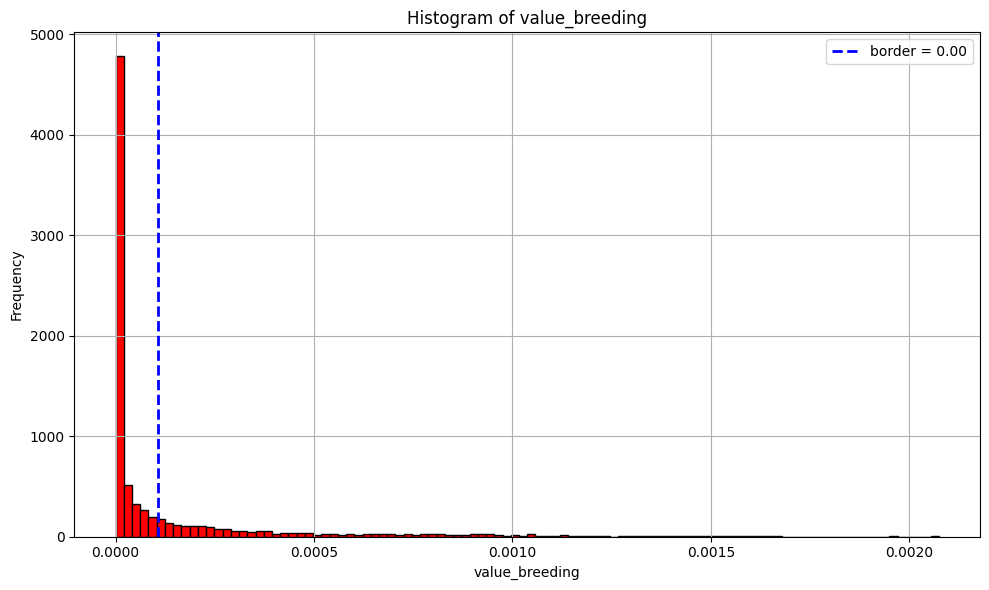

In [146]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df["value_breeding"], bins=100, color='red', edgecolor='black')
ax.axvline(breeding_favorite_border, color='blue', linestyle='--', linewidth=2, label=f'border = {breeding_favorite_border:.2f}')

ax.legend()
#ax.set_ylim(0, 200) 
ax.set_title("Histogram of value_breeding")
ax.set_xlabel("value_breeding")
ax.set_ylabel("Frequency")
ax.grid(True)
fig.tight_layout()
fig.savefig(f"{species}/plots/value_breeding_hist.pdf", dpi=300, bbox_inches="tight")
plt.show()

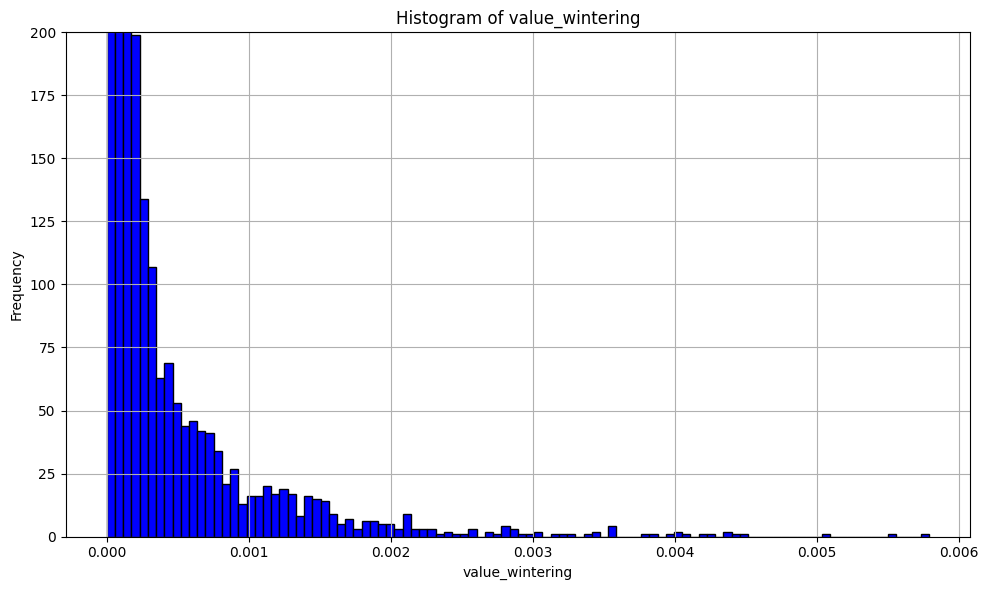

In [147]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df["value_wintering"], bins=100, color='blue', edgecolor='black')
ax.set_ylim(0, 200)  # This avoids using plt.ylim
ax.set_title("Histogram of value_wintering")
ax.set_xlabel("value_wintering")
ax.set_ylabel("Frequency")
ax.grid(True)
fig.tight_layout()
fig.savefig(f"{species}/plots/value_wintering_hist.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [148]:
# plot breeding abundance map
df.plot(column="value_breeding", linewidth=0.2, edgecolor=None, figsize=(30, 10), legend=True)
plt.savefig(f"{species}/plots/h3_b.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [149]:
# plot wintering abundance map
df.plot(column="value_wintering", linewidth=0.2, edgecolor=None, figsize=(30, 10), legend=True)
plt.savefig(f"{species}/plots/h3_w.pdf", dpi=300, bbox_inches="tight")
plt.close()

In [150]:
# plot difference map
df["diff"] = df["value_breeding"] / df["value_breeding"].max()  - df["value_wintering"] / df["value_wintering"].max()

# Determine the symmetric range around zero
max_abs = np.nanmax(np.abs(df["diff"]))
vmin, vmax = -1, 1

ax = df.plot(
    column="diff",
    linewidth=0,
    edgecolor=None,
    legend=True,
    cmap="coolwarm",  # diverging for positive/negative differences
    figsize=(30, 10),
    vmin=vmin,
    vmax=vmax  # ensures zero is in the center
)
plt.title("Breeding - Wintering")
plt.savefig(f"{species}/plots/h3_diff_norm.pdf", dpi=300, bbox_inches="tight")
plt.close()


In [151]:
# coordinates
latlng_map = df['cell'].apply(lambda c: pd.Series(h3.cell_to_latlng(c), index=['lat', 'lng']))
df = pd.concat([df, latlng_map], axis=1)

In [152]:
df = df.loc[:, ~df.columns.duplicated()]
df.head()

,value_wintering,value_breeding,cell,geometry,diff,lat,lng
0,0.0,0.000308,8402881ffffffff,"POLYGON ((-122.78191 72.57262, -123.18792 72.3...",0.148438,72.360893,-122.445505
1,0.0,0.000148,8402883ffffffff,"POLYGON ((-121.70156 72.3511, -122.11624 72.14...",0.071162,72.136879,-121.379940
2,0.0,0.000016,8402885ffffffff,"POLYGON ((-123.92858 72.37207, -124.31589 72.1...",0.007684,72.162553,-123.584452
3,0.0,0.000148,8402887ffffffff,"POLYGON ((-122.85116 72.15677, -123.24746 71.9...",0.071336,71.944705,-122.521422
4,0.0,0.000220,8402889ffffffff,"POLYGON ((-122.70944 72.98811, -123.12566 72.7...",0.105979,72.776741,-122.366100


In [153]:
df.to_csv(f'{species}/tables/h3_abundance.csv', index = False)

In [154]:
# Create dictionary
dict = df.set_index('cell').to_dict(orient='index')

In [155]:
# TODO ?? not needed really and hardcoded everywhere else anyway...
DEPARTURE_VALUE = 'value_wintering'
DESTINATION_VALUE = 'value_breeding'

In [ ]:
try:
    all_routes = pd.read_csv(f'{species}/tables/{species}_all_routes.csv')
except (FileNotFoundError, pd.errors.EmptyDataError):
    # Create all combinations of departure and destination
    all_routes = df[['cell', DEPARTURE_VALUE]].rename(columns={'cell': 'departure_cell', DEPARTURE_VALUE: 'departure_value'}) \
        .merge(df[['cell', DESTINATION_VALUE]].rename(columns={'cell': 'destination_cell', DESTINATION_VALUE: 'destination_value'}), how='cross')


    # Compute distance
    all_routes['length_km'] = all_routes.apply(
        lambda row: h3.great_circle_distance(
            (dict[row.departure_cell]['lat'], dict[row.departure_cell]['lng']),
            (dict[row.destination_cell]['lat'], dict[row.destination_cell]['lng']),
            unit='km'
        ),
        axis=1
    )
    
    all_routes.to_csv(f'{species}/tables/{species}_all_routes.csv', index = False)

In [ ]:
all_routes.head()

,departure_cell,departure_value,destination_cell,destination_value,length_km
0,840c001ffffffff,0.0,840c001ffffffff,0.000085,0.000000
1,840c001ffffffff,0.0,840c003ffffffff,0.000300,43.227198
2,840c001ffffffff,0.0,840c005ffffffff,0.000009,45.708461
3,840c001ffffffff,0.0,840c007ffffffff,0.000104,45.589850
4,840c001ffffffff,0.0,840c009ffffffff,0.000067,45.708461


In [ ]:
all_routes.shape

(25300900, 5)

# Model

In [ ]:
# 'leapfrog', 'chain', 'fcfs', 'naive', 'favorite leapfrog','favorite mix', 'favorite chain'
model = 'naive'
alpha = 0.1

In [ ]:
all_routes.head()

,departure_cell,departure_value,destination_cell,destination_value,length_km
0,840c001ffffffff,0.0,840c001ffffffff,0.000085,0.000000
1,840c001ffffffff,0.0,840c003ffffffff,0.000300,43.227198
2,840c001ffffffff,0.0,840c005ffffffff,0.000009,45.708461
3,840c001ffffffff,0.0,840c007ffffffff,0.000104,45.589850
4,840c001ffffffff,0.0,840c009ffffffff,0.000067,45.708461


In [ ]:
# TODO rewrite
# TODO check the warnigng fo 'favorite mix'

if model == 'naive':
    # Calculate flow
    routes = all_routes.copy()
    routes['flow'] = routes['departure_value'] * routes['destination_value']
    
else:
    if model == 'fcfs':
        routes = all_routes.merge(
            df[['cell', 'value_breeding']],
            left_on='destination_cell',
            right_on='cell',
            how='left'
        )

        routes = routes.sort_values(
            by=['value_breeding', 'length_km'],
            ascending=[False, True]
        )

    elif model == 'favorite leapfrog':
        routes = all_routes.merge(
            df[['cell', 'value_breeding']],
            left_on='destination_cell',
            right_on='cell',
            how='left'
        )

        favorites = routes[routes['value_breeding'] > breeding_favorite_border].sort_values(by='length_km', ascending=True)
        the_rest = routes[routes['value_breeding'] <= breeding_favorite_border].sort_values(by='length_km', ascending=True)

        routes = pd.concat([favorites, the_rest], ignore_index=True)
    
    elif model == 'favorite mix':
        # TODO check this
        routes = all_routes.merge(
            df[['cell', 'value_breeding']],
            left_on='destination_cell',
            right_on='cell',
            how='left'
        ).drop(columns=['cell'])

        merged = routes.merge(
            df[['cell', 'lat']],
            left_on='departure_cell',
            right_on='cell',
            how='left'
        ).drop(columns=['cell'])

        favorites = merged[merged['value_breeding'] > breeding_favorite_border].sort_values(by='length_km', ascending=True)
        the_rest = merged[merged['value_breeding'] <= breeding_favorite_border]

        max_distance = the_rest['length_km'].max()
        max_lat = the_rest['lat'].max()
        min_lat = the_rest['lat'].min()

        # Vectorized penalty calculation
        penalty = max_distance * (1 - (max_lat - the_rest['lat']) / (max_lat - min_lat))
        
        the_rest['length_km'] += penalty
        the_rest = the_rest.sort_values(by='length_km', ascending=True)
        
        routes = pd.concat([favorites, the_rest], ignore_index=True)


    elif model == 'favorite chain':
        # TODO check this
        routes = all_routes.merge(
            df[['cell', 'value_breeding']],
            left_on='destination_cell',
            right_on='cell',
            how='left'
        ).drop(columns=['cell'])

        merged = routes.merge(
            df[['cell', 'lat']],
            left_on='departure_cell',
            right_on='cell',
            how='left'
        ).drop(columns=['cell'])

        favorites = merged[merged['value_breeding'] > breeding_favorite_border].sort_values(by='length_km', ascending=True)
        the_rest = merged[merged['value_breeding'] <= breeding_favorite_border]

        max_distance = favorites['length_km'].max()
        max_lat = favorites['lat'].max()
        min_lat = favorites['lat'].min()

        # Vectorized penalty calculation
        penalty = max_distance * (1 - (max_lat - favorites['lat']) / (max_lat - min_lat))
        favorites['length_km'] += penalty
        favorites = favorites.sort_values(by='length_km', ascending=True)


        max_distance = the_rest['length_km'].max()
        max_lat = the_rest['lat'].max()
        min_lat = the_rest['lat'].min()

        # Vectorized penalty calculation
        penalty = max_distance * (1 - (max_lat - the_rest['lat']) / (max_lat - min_lat))
        the_rest['length_km'] += penalty
        the_rest = the_rest.sort_values(by='length_km', ascending=True)
        
        routes = pd.concat([favorites, the_rest], ignore_index=True)


    else: 
        routes = all_routes.copy()
        if model == 'chain':
            # Merge once
            merged = all_routes.merge(
                df[['cell', 'lat']],
                left_on='departure_cell',
                right_on='cell',
                how='left'
            ).drop(columns=['cell'])

            # Precompute constants
            max_distance = merged['length_km'].max()
            max_lat = merged['lat'].max()
            min_lat = merged['lat'].min()

            # Vectorized penalty calculation
            penalty = max_distance * (1 - (max_lat - merged['lat']) / (max_lat - min_lat))

            # Update in place
            merged['length_km'] += penalty

            routes = routes.sort_values(by='length_km')

        elif model == 'leapfrog':
            routes = routes.sort_values(by='length_km')
        
        else:
            raise ValueError("no such model")
    
    dict_copy = copy.deepcopy(dict)
    flows = []
    for row in routes.itertuples(index=True):
        f = min(alpha * dict_copy[row.departure_cell]['value_wintering'],
                dict_copy[row.destination_cell]['value_breeding'])
        flows.append(f)

        dict_copy[row.departure_cell]['value_wintering'] -= f
        dict_copy[row.destination_cell]['value_breeding'] -= f

    routes['flow'] = flows

/tmp/ipykernel_439316/282120994.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  the_rest['length_km'] += penalty


In [ ]:
routes.head()

,departure_cell,departure_value,destination_cell,destination_value,length_km,value_breeding,lat,flow
0,840c72dffffffff,0.0,840c72dffffffff,0.000234,0.0,0.000234,62.362718,0.0
1,840c1ddffffffff,0.0,840c1ddffffffff,0.000657,0.0,0.000657,62.625361,0.0
2,840f5b3ffffffff,0.0,840f5b3ffffffff,0.001408,0.0,0.001408,56.923483,0.0
3,840e2abffffffff,0.0,840e2abffffffff,0.001167,0.0,0.001167,59.358819,0.0
4,840e42bffffffff,0.0,840e42bffffffff,0.000975,0.0,0.000975,53.260970,0.0


In [ ]:
routes_nonzero = routes[routes["flow"] != 0]

In [ ]:
print(routes_nonzero.flow.sum())

0.9996294892070341


In [ ]:
routes_nonzero.head()

,departure_cell,departure_value,destination_cell,destination_value,length_km,value_breeding,lat,flow
3196796,8467569ffffffff,0.000188,842a36dffffffff,0.000977,3515.705487,0.000977,12.441591,0.000019
3197811,846756dffffffff,0.000016,842a36dffffffff,0.000977,3516.886250,0.000977,12.431820,0.000002
3210739,846756dffffffff,0.000016,842b8c3ffffffff,0.000494,3532.854005,0.000494,12.431820,0.000001
3211547,8467569ffffffff,0.000188,842b8c3ffffffff,0.000494,3533.895816,0.000494,12.441591,0.000017
3221050,8467569ffffffff,0.000188,842ba97ffffffff,0.001035,3545.862517,0.001035,12.441591,0.000015


In [ ]:
routes_nonzero.shape

(1616245, 8)

In [ ]:
os.makedirs(f"{species}/tables/{model}", exist_ok=True)
routes_nonzero.to_csv(f"{species}/tables/{model}/{model}_{alpha}.csv", index=False)

# Plots

In [ ]:
# routes_nonzero = pd.read_csv(f"{species}/tables/{model}/{model}_{alpha}.csv")

In [27]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, IntSlider, Output, interactive, Play, VBox, jslink
from IPython.display import HTML

In [28]:
# %matplotlib widget

In [29]:
df_plot = df.copy()
df_plot["abundance"] = df_plot["value_wintering"].copy()
df_plot.drop(columns=["value_breeding", "value_wintering", "diff", "lat", "lng"], inplace=True)

In [30]:
batch_size = 100000

In [31]:
# cache = [df_plot.copy()]

# for start in range(0, len(routes_nonzero), batch_size):
#     end = min(start + batch_size, len(routes_nonzero))

#     # Apply flows up to the current step
#     flows = routes_nonzero[start:end].groupby("departure_cell")["flow"].sum()
#     df_plot.loc[df_plot["cell"].isin(flows.index), "abundance"] -= df_plot["cell"].map(flows).astype("float32")

#     flows = routes_nonzero[start:end].groupby("destination_cell")["flow"].sum()
#     df_plot.loc[df_plot["cell"].isin(flows.index), "abundance"] += df_plot["cell"].map(flows).astype("float32")

#     cache.append(df_plot.copy())

In [32]:
cache = [df_plot.copy()]

cells = df_plot.set_index("cell")  # fast lookup by cell

for start in range(0, len(routes_nonzero), batch_size):
    end = min(start + batch_size, len(routes_nonzero))
    batch = routes_nonzero.iloc[start:end]

    # Net flow per cell in this batch: -departures + arrivals
    net_flows = (
        batch.groupby("departure_cell")["flow"].sum().rename("outflow").mul(-1)
        .add(batch.groupby("destination_cell")["flow"].sum(), fill_value=0)
    )

    # Update abundances in place
    cells.loc[net_flows.index, "abundance"] += net_flows.astype("float32")

    cache.append(cells.reset_index().copy())


## Prerendered animation

In [33]:
import matplotlib as mpl
mpl.rcParams['animation.embed_limit'] = 50 * 1024**2  # 50 MB

In [ ]:
fig, ax = plt.subplots(figsize=(12, 7), dpi=150)
vmax = np.nanmax(df[["value_breeding", "value_wintering"]])
norm=plt.Normalize(vmin=0, vmax=vmax)
plt.tight_layout()
sm = plt.cm.ScalarMappable(cmap="magma_r", norm=norm)
fig.colorbar(sm, ax=ax)

# Initial plot
plot = cache[0].plot(
    column="abundance",
    cmap="magma_r",
    linewidth=0.2,
    edgecolor="black",
    ax=ax,
    legend=False,
    norm=norm
)

# --- Animation update function ---
def update(step):
    df_step = cache[step]
    new_values = df_step["abundance"].values
    new_norm = plt.Normalize(vmin=0, vmax=new_values.max())
    
    sm.set_norm(new_norm)
    c = ax._children[0]
    c.set_array(new_values)
    c.set_norm(new_norm)

    ax.set_title(f"Abundance after {step} steps")

    return [plot]

# Reduce frames if needed for memory
frame_indices = range(0, len(cache), 1)  # use step>1 if cache is huge

ani = FuncAnimation(
    fig,
    update,
    frames=frame_indices,
    interval=100,
    blit=False  # blit=True can cause issues in Jupyter, False is safe
)

# Display animation
display(HTML(ani.to_jshtml()))
plt.close(fig)

In [35]:
ani.save(f"{species}/plots/{model}_{alpha}.gif", writer="pillow", fps=10)